In [70]:
import os
import random
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix

In [71]:
# device configuration
device=torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [72]:
normal_folder = 'data/Normal/'
diseased_folder = 'data/Sick/'

# Get a list of file names in each folder
normal = [os.path.join(normal_folder, file) for file in os.listdir(normal_folder)]
diseased = [os.path.join(diseased_folder, file) for file in os.listdir(diseased_folder)]

# Combine data and labels
all_files = normal + diseased
random.shuffle(all_files)
labels=[]
class_folders=[normal_folder,diseased_folder]
for img_loc in all_files:
    for class_idx, class_folder in enumerate(class_folders):
            if class_folder in img_loc:
                labels.append(class_idx)
                break

In [73]:
# creating a dataframe using the two list
IMAGE_HEIGHT=128
IMAGE_WIDTH=128
BATCH_SIZE=64
data = {'file_name': [os.path.basename(path) for path in all_files],
        'label': labels,
        'path': all_files}
df=pd.DataFrame(data)

In [74]:
df.tail(10)

,file_name,label,path
50,C13.jpg,1,data/Sick/C13.jpg
51,C4.jpg,1,data/Sick/C4.jpg
52,N3.jpg,0,data/Normal/N3.jpg
53,C16.jpg,1,data/Sick/C16.jpg
54,N24.jpg,0,data/Normal/N24.jpg
55,C14.jpg,1,data/Sick/C14.jpg
56,N1.jpg,0,data/Normal/N1.jpg
57,N20.jpg,0,data/Normal/N20.jpg
58,N11.jpg,0,data/Normal/N11.jpg
59,N2.jpg,0,data/Normal/N2.jpg


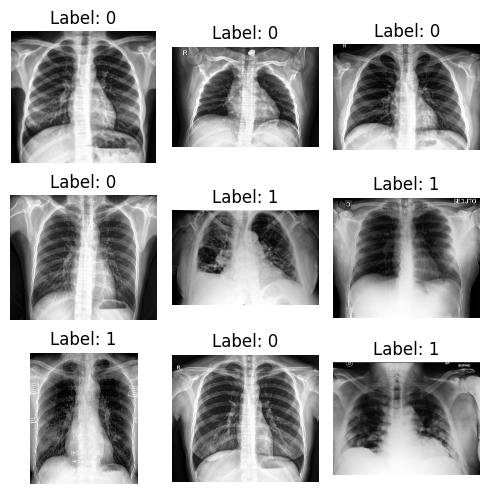

In [75]:

fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for row in axes:
    for ax in row:
        idx = random.randint(0, len(df) - 1)
        img = Image.open(df.loc[idx, 'path'])
        ax.imshow(img)
        ax.set_title(f"Label: {df.loc[idx, 'label']}")
        ax.axis('off')
plt.tight_layout()
plt.show()

In [76]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df,test_size=0.6,random_state=42)

In [77]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(48, 3)
(8, 3)
(4, 3)


**Data transformation**
<!-- - resize,normalize methods to all sets(train,test) -->
<!-- - augmentation technique is applied to only train set -->

In [78]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(224,224)),
    transforms.RandomHorizontalFlip(p=.05),
    transforms.RandomVerticalFlip(p=.05),
    transforms.RandomRotation(degrees=20), 
    transforms.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 2)),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # Add random affine
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
     transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])


# transform whole dataset for visualization purpose
data_transform = transforms.Compose([
    transforms.Resize(size=(224)),
    transforms.ToTensor(),
])

In [79]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 2]  # Index 2 corresponds to 'file path' column
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])  # Index 1 corresponds to 'label' column
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [80]:
# create dataset and data loaders
train_dataset = CustomDataset(train_df, transform=train_transform)
val_dataset=CustomDataset(val_df,transform=val_transform)
test_dataset = CustomDataset(test_df, transform=test_transform)
whole_dataset = CustomDataset(df, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=16, num_workers=0,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=16,num_workers=0,shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=0,shuffle=False)
whole_loader = DataLoader(df, batch_size=16, shuffle=False)

In [81]:
#get some random data from training set and let's see
dataiter=iter(train_loader)
images,labels=next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


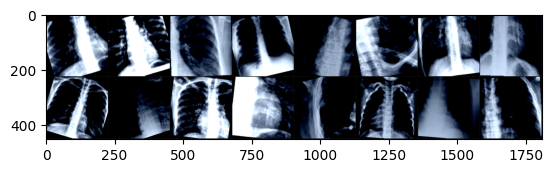

In [82]:
#plotting some data
def imshow(img):
    img=img/2+.05  #unnormalize
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))

In [83]:
print(images.shape)

torch.Size([16, 3, 224, 224])


In [84]:
num_epochs=10
learning_rate=1e-4
batch_size=16
load_model=True
wt_decay=.0001



In [85]:
class MedicalCNN(nn.Module):
    def __init__(self,dropout_prob=0.5):
        super(MedicalCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)  # Adjust the input size based on your image dimensions
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout layer
        self.fc2 = nn.Linear(128,2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)  # Flatten the features
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x) 
        x = self.fc2(x)
        return x


In [86]:
model=MedicalCNN(dropout_prob=.5).to(device)

In [87]:
print(model)

MedicalCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [88]:
#loss
criterion=nn.CrossEntropyLoss()
#optimizer
#optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=wt_decay)
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=wt_decay)

In [89]:
# Function to save a checkpoint
def save_checkpoint(state, filename='checkpoints/customCNN/checkpoint.pth'):
    torch.save(state, filename)
# Function to load a checkpoint
def load_checkpoint(model, optimizer, filename='checkpoints/customCNN/checkpoint.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer


In [90]:
#train network

# Set up early stopping
best_loss = float('inf')
patience = 3  # Number of epochs without improvement to wait before early stopping
counter = 0
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    model.train()

    # if epoch % 3 == 0:
    #     checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
    #     save_checkpoint(checkpoint)
    
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [32, 3, 224, 224] = 4, 3, 224*224
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        save_checkpoint(checkpoint, filename=f'checkpoints/customCNN/best_checkpoint.pth')
        
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break
print('Finished Training')

Epoch [1/10], Loss: 0.6924, Validation Loss: 0.6926
Epoch [2/10], Loss: 0.6953, Validation Loss: 0.6919
Epoch [3/10], Loss: 0.6991, Validation Loss: 0.6914
Epoch [4/10], Loss: 0.6903, Validation Loss: 0.6912
Epoch [5/10], Loss: 0.6934, Validation Loss: 0.6914
Epoch [6/10], Loss: 0.6911, Validation Loss: 0.6912
Epoch [7/10], Loss: 0.6812, Validation Loss: 0.6917
Early stopping triggered
Finished Training


In [91]:
# Load the best checkpoint and test the model
if load_model:
    best_model = MedicalCNN(dropout_prob=.5).to(device)
    best_optimizer = torch.optim.SGD(best_model.parameters(), lr=learning_rate,weight_decay=wt_decay)
    best_model, best_optimizer = load_checkpoint(best_model, best_optimizer, filename='checkpoints/customCNN/best_checkpoint.pth')

    best_model.eval()
    train_loss = 0.0
    correct = 0
    total = 0
    #training loss and training accuracy
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = best_model(images)
            train_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {accuracy:.3%}')


Training Loss: 0.6897, Training Accuracy: 64.583%


Test Loss: 0.6913, Test Accuracy: 62.50%
f1 score on test set is: 0.0


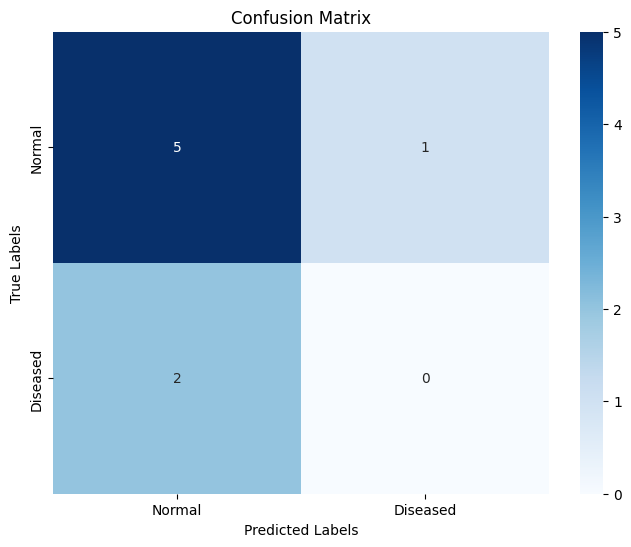

In [92]:
# Load the best checkpoint and test the model
if load_model:
    best_model = MedicalCNN(dropout_prob=.5).to(device)
    best_optimizer = torch.optim.SGD(best_model.parameters(), lr=learning_rate,weight_decay=wt_decay)
    best_model, best_optimizer = load_checkpoint(best_model, best_optimizer, filename='checkpoints/customCNN/best_checkpoint.pth')

    best_model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    #training loss and training accuracy
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = best_model(images)
            test_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    f1 = f1_score(all_labels, all_predictions)
    test_loss /= len(test_loader)
    accuracy = correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2%}')
    print(f"f1 score on test set is: {f1}")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Diseased'], yticklabels=['Normal', 'Diseased'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()